# Naive Approach

In [1]:
# init prerequisites
%reload_ext autoreload
%autoreload 2
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import matplotlib.dates as dates
import os, re, math, time, random
from pprint import pprint

from skimage import measure

import util
from util import print_warn, horline

print("OpenCV {}".format(cv.__version__))
print("Numpy {}".format(np.__version__))

OpenCV 3.4.1
Numpy 1.16.2


In [2]:
# gasonics production equipment
config = dict(
    inputfolder="./input/classes_r3",
    outputfolder="./output/naive",
)
pprint(config)

os.makedirs(config["outputfolder"], exist_ok=True)

{'inputfolder': './input/classes_r3', 'outputfolder': './output/naive'}


In [3]:
def save_img(saveimgs):
    os.makedirs(config["outputfolder"], exist_ok=True)
    for img, name in saveimgs:
        imgpath = os.path.join(config["outputfolder"], name)
        cv.imwrite(imgpath, img)
        print("image saved to {}".format(imgpath))

def wait_and_hotkey(saveimgs, delay: int) -> bool:
    k = cv.waitKey(delay) & 0xff
    if k == 32:
        while True:
            k = cv.waitKey(10) & 0xff
            if k == 27: return True
            elif k == 32: break
            elif k == ord('s'):
                save_img(saveimgs)
    elif k == 27: return True
    elif k == ord('s'): 
        save_img(saveimgs)
    return False

In [4]:
if True:
    ## dat = [ dict(raw=[], thres=[], offset=[]) for i in range(len(points))]
    def decide(dat):
        def out(x): return label_mapping[x][1]
        def last(dat): return dat["thres"][-1]
        if last(dat[2]) < 50 and last(dat[3]) < 50:
            return out( 4), ( 32,  61) # cassete location
        elif last(dat[2]) < 50 and last(dat[3]) > 50:
            return out(10), (298, 524) # cooling_station
        elif last(dat[1]) < 50 and last(dat[2]) > 50 and last(dat[3]) > 50:
            return out( 8), (805, 495) # process_chamber
        else:
            return out( 6), (658, 182) # idle at process chamber
        
    def apply_offset(i, val):
        if val == 255:
            val = 100 + (i) * 5
        elif val == 0:
            val =   0 + (i) * 5
        return val

    def hysteresis(lower, upper):
        def func(prev, value):
            return 255 if value>upper else 0 if value<lower else prev
        return func

points = [
    [(330,470), [], "Cooling Station"],
    [(650,450), [], "Process Chamber Door"],
    [(850, 50), [], "Robot Cooling Station"],
    [(940,100), [], "Robot Cassette Location"],
    [(390,300), [], "Robot Arm CS"],
]

threshold = [
     #, custom function     , hide
    [0, hysteresis(200, 240), True],
    [0, hysteresis( 80, 150), True],
    [0, hysteresis( 50,  80), True],
    [0, hysteresis( 50, 100), True],
    [0, hysteresis(100, 150), True],
]

{0: (129, '1_home'),
 1: (128, '2.1_moving'),
 2: (117, '2.2_moving_wafer'),
 3: (188, '3.1_cassette_location_empty'),
 4: (198, '3.2_cassette_location_unknown'),
 5: (163, '3.3_cassette_location_wafer'),
 6: (399, '4.1_processchamber_empty'),
 7: (206, '4.2_processchamber_unknown'),
 8: (141, '4.3_processchamber_wafer'),
 9: (106, '5.1_cooling_station_wafer'),
 10: (149, '5.2_cooling_station_unknown'),
 11: (170, '5.3_cooling_station_empty')}


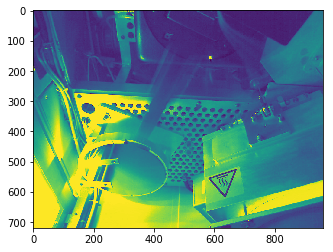

In [5]:
# clear previous result
for p in points:
    p[1] = list()
    
# collect input files
paths, labels, label_mapping = util.recursive_collect(config["inputfolder"])
pprint(label_mapping)

# merge paths and labels, sort together and split again
paths = list(zip(paths, labels))
paths = sorted(paths, key = lambda x: x[0].split("\\")[-1])
paths, labels = zip(*paths[300:]) # skip first 300

# one time initialization
#clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))

img = cv.imread(paths[300], cv.IMREAD_GRAYSCALE)
plt.imshow(img); plt.show()

point_data = [ dict(raw=[], thres=[], offset=[]) for i in range(len(points))]
states = []
images = []
result = []

font = cv.FONT_HERSHEY_SIMPLEX
cv.destroyAllWindows()
for i, path, label in zip(range(len(paths)), paths, labels):
    # read input image and store for future use
    img = cv.imread(path, cv.IMREAD_GRAYSCALE)
    img = cv.medianBlur(img, 5)
    img = cv.equalizeHist(img)
    img = cv.cvtColor(img, cv.COLOR_GRAY2BGR)
    
    for pi, p, t, dat in zip(range(len(points)), points, threshold, point_data):
        pxval = img[p[0][1]][p[0][0]][0]
        dat["raw"].append(pxval)

        # apply custom threshold function
        thres = dat["thres"][-1] if i > 0 else -1
        thres = t[1](thres, pxval)
        dat["thres"].append(thres)
        
        # apply offset for easier graph reading
        offset = apply_offset(pi, thres)
        dat["offset"].append(offset)
        
        cv.circle(img, p[0], 5, (255,0,0), 5)
        cv.circle(img, p[0], 1, (thres,thres,thres), 5)
        cv.putText(img, str(pxval), (p[0][0] - 20, p[0][1] + 30), font, 0.8, (0,0,0), 2, cv.LINE_AA)
        p[1].append(pxval)
        
    states.append(label)
    images.append(path.split("\\")[-1])
        
    # all points have been evaluated, decide
    decision = decide(point_data)
    result.append(decision[0])
    cv.putText(img, str(decision[0]), (10,30), font, 0.8, (255,255,255), 2, cv.LINE_AA)
    cv.circle(img, decision[1], 5, (0,255,0), 5)
    cv.imshow('img', img)
    
    if wait_and_hotkey([(img, "{}-{}.png".format(i, os.path.basename(path)))], delay=50): break
cv.destroyAllWindows()

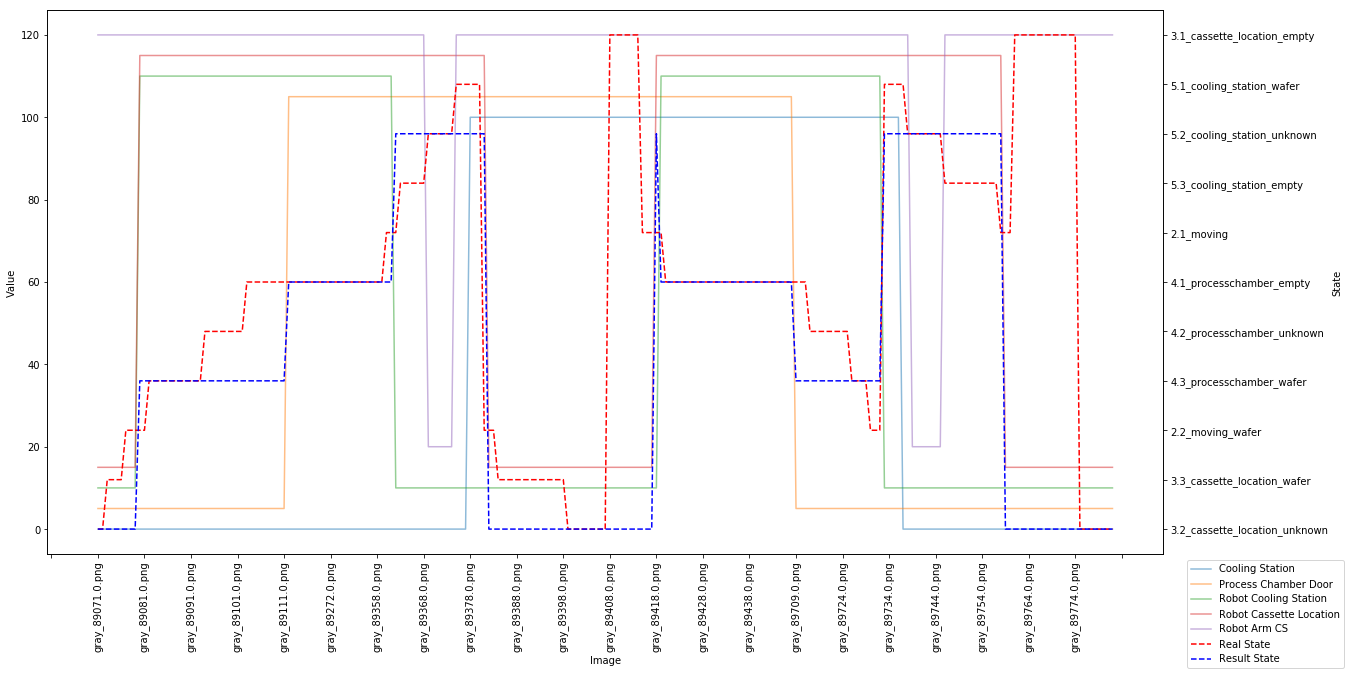

In [6]:
values = None

fig, ax1 = plt.subplots(figsize = (20, 10))
plt.xticks(rotation=90)

for i, el, t, dat in zip(range(len(points)), points, threshold, point_data):
    if len(dat["offset"]) > 0:
        ax1.plot(images, dat["offset"], label=el[2], alpha=0.5)
    if not t[2]: # hide plot of raw data
        ax1.plot(images, dat["raw"], label=el[2], alpha=0.5)

ax1.set_xlabel('Image')
ax1.set_ylabel('Value')
  
ax2 = ax1.twinx()
ax2.set_ylabel('State')
ax2.plot(images, list(map(lambda x: str((label_mapping[x][1])),states)), "r--", label="Real State")
ax2.plot(images, result, "b--", label="Result State")

#ax3 = ax1.twinx()
#ax3.set_ylabel('Result State')
#ax3.spines["right"].set_position(("axes", 0.97))

ax2.xaxis.set_major_locator(plticker.MultipleLocator(base=10))

fig.legend(loc="lower right")
plt.savefig(os.path.join(config["outputfolder"],"naive-graph.svg"), format="svg", bbox_inches='tight')
plt.show()

In [ ]:
cv.destroyAllWindows()